Importation des modules nécessaires à l'algorithme

In [7]:
import tempfile
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import filters
import cv2
import time
import random

Fonctions basiques

In [8]:
def viewimage(im, normalize=True,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

Pre-processing : Black Frame Removal

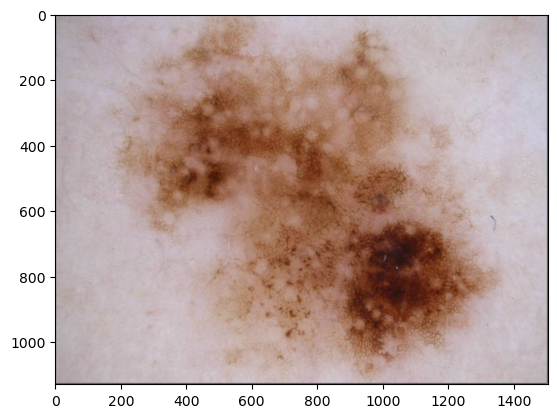

In [9]:
FilePath = "/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-201/Projet/ima201-skinlesions-billykaeppelin/skin_lesion_dataset-master/melanoma"
FileName = "/ISIC_0000049.jpg"

im=io.imread(FilePath+FileName)
plt.imshow(im)

In [10]:
import numpy as np

def remove_black_frame(im):
    # Calcul de la luminosité
    im_lightness = np.zeros((im.shape[0], im.shape[1]))
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            luminosity = (max(im[row][column]) + min(im[row][column])) // 2
            if luminosity < 60:
                im_lightness[row][column] = 0
            else:
                im_lightness[row][column] = 1
    
    # Suppression du cadre noir - Numérisation de haut en bas
    seuil = 0
    row = 0
    while seuil < 0.6:
        S = np.sum(im_lightness[row, :])
        seuil = S / im.shape[1]
        row += 1

    # Suppression du cadre noir - Numérisation de gauche à droite
    seuil = 0
    column = 0
    while seuil < 0.6:
        S = np.sum(im_lightness[:, column])
        seuil = S / im.shape[0]
        column += 1
    
    # Suppression du cadre noir - Numérisation de droite à gauche
    seuil = 0
    column_reverse = im.shape[1] - 1
    while seuil < 0.6:
        S = np.sum(im_lightness[:, column_reverse])
        seuil = S / im.shape[0]
        column_reverse -= 1

    # Suppression du cadre noir - Réduction de l'image
    im_cropped = im[row:, column:column_reverse]
    
    return im_cropped


In [11]:
im_cropped= remove_black_frame(im)
print(im_cropped.shape)

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_4287/1531101031.py:8: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2


(1128, 1501, 3)


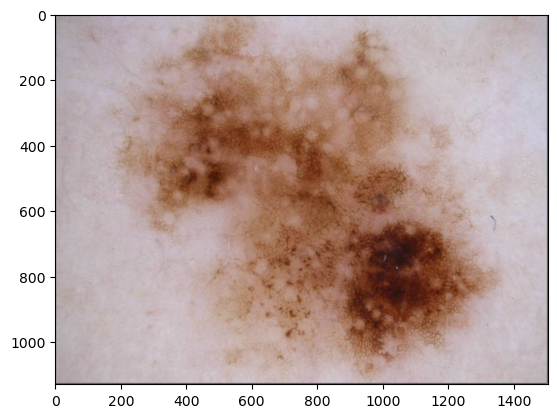

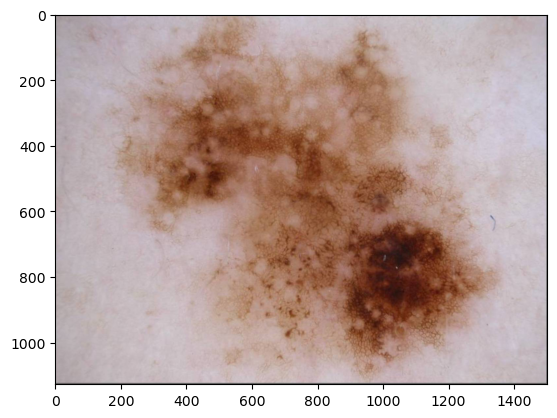

In [12]:
plt.figure("1")
plt.imshow(im)
plt.figure("2")
plt.imshow(im_cropped)

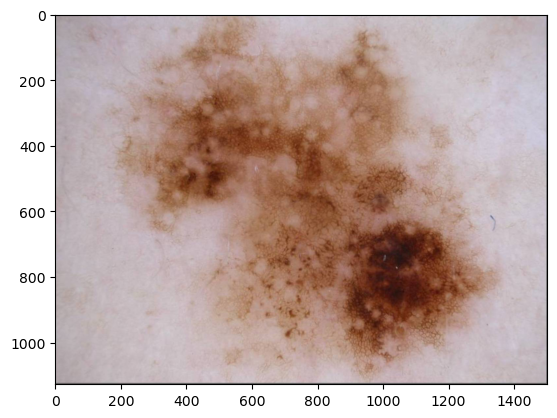

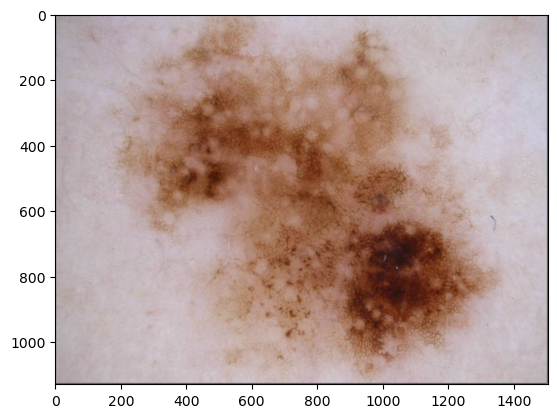

In [13]:
plt.figure("1")
plt.imshow(im_cropped)
plt.figure("2")
plt.imshow(im)

Image smoothing - Median filter

11


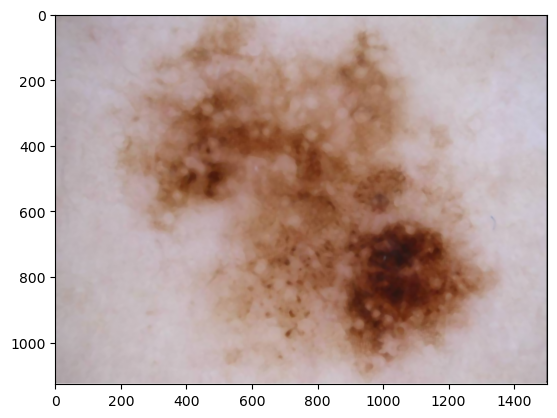

In [14]:
M=im_cropped.shape[0]
N=im_cropped.shape[1]
kernel_size=int(np.floor(5*np.sqrt((M/768)*(N/512))))
if kernel_size%2==0:
    kernel_size+=1
print(kernel_size)
image_filtree = cv2.medianBlur(im_cropped, kernel_size)
plt.imshow(image_filtree)

Implémentation de l'algorithme de SRM

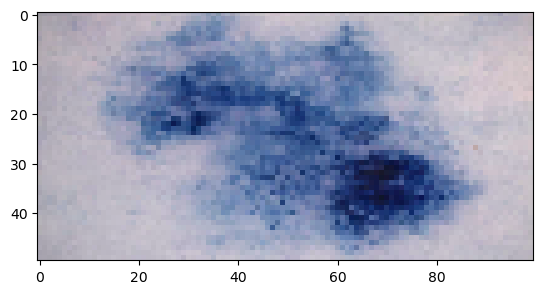

In [15]:
import cv2
import matplotlib.pyplot as plt

# Charger une image
image = cv2.imread(FilePath+FileName)

# Réduire la taille de l'image
im_reduced = cv2.resize(image, (100, 50))

# Afficher l'image réduite
plt.imshow(im_reduced)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


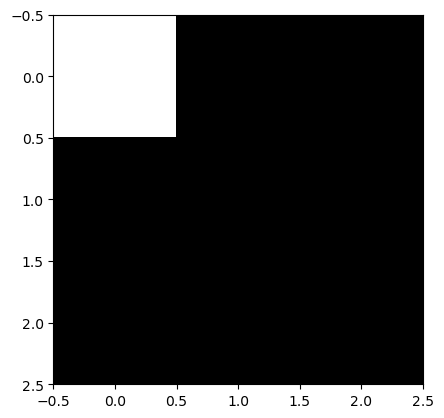

In [16]:
#Préparation d'une image trivial pour tester la focntion SRM_segmentation
im_trivial=np.zeros((3,3,3))
im_trivial[0][0]=[255,255,255]
plt.imshow(im_trivial)

In [17]:

class Pixel:
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value

class Region:
    def __init__(self, pixel):
        self.pixels = [pixel]  # Liste des pixels de la région
        self.statistics = self.calculate_statistics()  # Propriétés statistiques de la région

    def calculate_statistics(self):
        # Calcule les statistiques de la région, par exemple la moyenne et l'écart type des valeurs de pixel
        #print(self.pixels[0].value)
        pixel_values = [pixel.value for pixel in self.pixels]
        mean = np.mean(pixel_values)
        std_dev = np.std(pixel_values)
        return {'mean': mean, 'std_dev': std_dev}

def calculate_similarity(region1, region2):
    # Calcule la similarité entre deux régions en comparant leurs statistiques, par exemple en utilisant la différence des moyennes
    mean_diff = abs(region1.statistics['mean'] - region2.statistics['mean'])
    return mean_diff




SRM_segmentation

In [18]:
def créer_matrice_regions(image,regions):
    matrice_regions=np.zeros((image.shape[0],image.shape[1]))
    r=0
    numero_region=[]
    for x in range(len(regions)):
        for y in range(len(regions[0])):
            if regions[x][y] is not None:
                numero_region.append(r)
                for i in regions[x][y].pixels:
                    matrice_regions[i.x][i.y]=int(r)
                r+=1
    return matrice_regions, numero_region

In [19]:
def créer_image_region(matrice_regions,numero_region):
    image_region=np.zeros((matrice_regions.shape[0],matrice_regions.shape[1],3))
    for i in range(len(numero_region)):
        numero_region[i] = np.array([0,random.randint(0,255),random.randint(0,255)],dtype=np.uint8)
    for x in range(matrice_regions.shape[0]):
        for y in range(matrice_regions.shape[1]):
            image_region[x][y]=numero_region[int(matrice_regions[x][y])]
    return image_region.astype(np.uint8)

rows :  3
cols :  3
Nombre de régions au début:  9
similarity :  255.0
min_similarity :  255.0
similarity :  0.0
min_similarity :  0.0
similarity :  0.0
similarity :  0.0
similarity :  0.0
similarity :  0.0
fusion des deux régions0111
regions[x1][y1].statistics :  {'mean': 0.0, 'std_dev': 0.0}
Temps restant : 0.00 secondes
[[<__main__.Region object at 0x162f4edd0>, <__main__.Region object at 0x162f4f4d0>, <__main__.Region object at 0x162d77290>], [<__main__.Region object at 0x162f4ee50>, None, <__main__.Region object at 0x162f4f050>], [<__main__.Region object at 0x162f4f0d0>, <__main__.Region object at 0x162f4f150>, <__main__.Region object at 0x162f4f1d0>]]
[<__main__.Pixel object at 0x162eec7d0>, <__main__.Pixel object at 0x162f4eed0>]


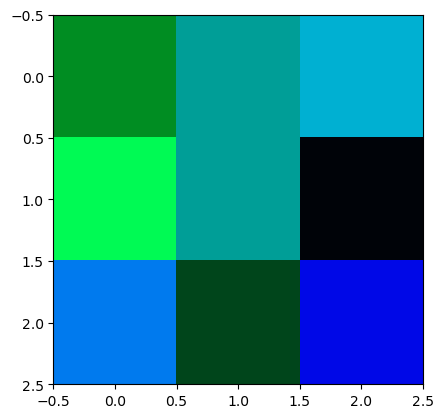

similarity :  255.0
min_similarity :  255.0
similarity :  0.0
similarity :  0.0
similarity :  0.0
fusion des deux régions0102
regions[x1][y1].statistics :  {'mean': 0.0, 'std_dev': 0.0}
Temps restant : 0.15 secondes
[[<__main__.Region object at 0x162f4edd0>, <__main__.Region object at 0x162f4f350>, None], [<__main__.Region object at 0x162f4ee50>, None, <__main__.Region object at 0x162f4f050>], [<__main__.Region object at 0x162f4f0d0>, <__main__.Region object at 0x162f4f150>, <__main__.Region object at 0x162f4f1d0>]]
[<__main__.Pixel object at 0x162eec7d0>, <__main__.Pixel object at 0x162f4eed0>, <__main__.Pixel object at 0x162ea61d0>]


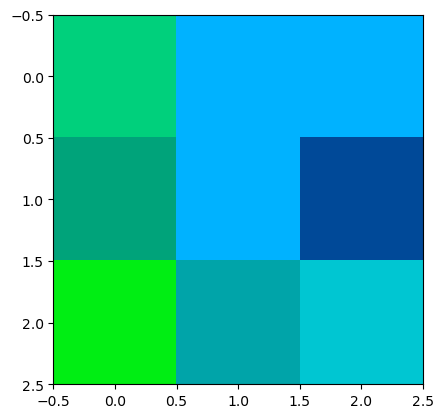

similarity :  255.0
min_similarity :  255.0
similarity :  0.0
min_similarity :  0.0
similarity :  0.0
fusion des deux régions1020
regions[x1][y1].statistics :  {'mean': 0.0, 'std_dev': 0.0}
Temps restant : 0.16 secondes
[[<__main__.Region object at 0x162f4edd0>, <__main__.Region object at 0x162f4f350>, None], [<__main__.Region object at 0x162ddd610>, None, <__main__.Region object at 0x162f4f050>], [None, <__main__.Region object at 0x162f4f150>, <__main__.Region object at 0x162f4f1d0>]]
[<__main__.Pixel object at 0x162f4ee10>, <__main__.Pixel object at 0x162f4f110>]


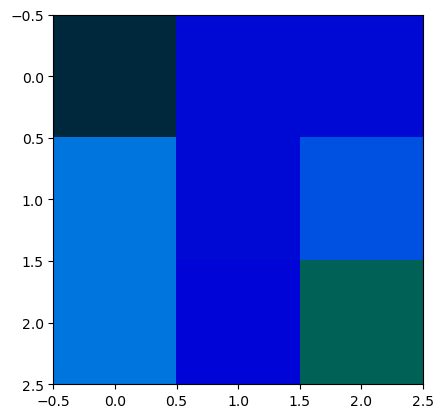

similarity :  255.0
min_similarity :  255.0
similarity :  0.0
min_similarity :  0.0
fusion des deux régions1222
regions[x1][y1].statistics :  {'mean': 0.0, 'std_dev': 0.0}
Temps restant : 0.16 secondes
[[<__main__.Region object at 0x162f4edd0>, <__main__.Region object at 0x162f4f350>, None], [<__main__.Region object at 0x162ddd610>, None, <__main__.Region object at 0x162fe9390>], [None, <__main__.Region object at 0x162f4f150>, None]]
[<__main__.Pixel object at 0x162f4f090>, <__main__.Pixel object at 0x162f4f210>]


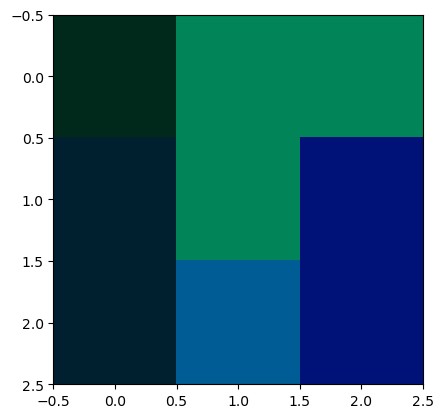

similarity :  255.0
min_similarity :  255.0
Nombre de régions restantes:  5


In [20]:

def SRM_segmentation(image, seuil_similarity, canal=2):
    # Initialisation : chaque pixel est une région
    rows, cols = image.shape[0],image.shape[1]
    print("rows : ", rows)
    print("cols : ", cols)            
    regions = [[Region(Pixel(x, y, image[x,y][canal])) for y in range(cols)] for x in range(rows)]
    nb_regions_ini = len(regions)*len(regions[0])
    print("Nombre de régions au début: ", len(regions)*len(regions[0]))
    # Fusion des régions
    start_time = time.time()
    while True:
        n=0
        min_similarity = float('inf')
        regions_to_merge = None
        merge_occurred = False  # Variable pour suivre si une fusion a eu lieu dans cette itération
        # Recherche des paires de régions les plus similaires
        for x in range(rows):
            for y in range(cols):   
                if x < rows - 1 and regions[x][y] is not None and regions[x+1][y] is not None:
                    similarity = calculate_similarity(regions[x][y], regions[x + 1][y])
                    print("similarity : ", similarity)
                    if similarity < min_similarity:
                        min_similarity = similarity
                        print("min_similarity : ", min_similarity)
                        regions_to_merge = ((x, y), (x + 1, y))
                        
                if y < cols - 1 and regions[x][y] is not None  and regions[x][y+1] is not None:
                    similarity = calculate_similarity(regions[x][y], regions[x][y + 1])
                    if similarity < min_similarity:
                        min_similarity = similarity
                        regions_to_merge = ((x, y), (x, y + 1))
                    
        # Vérification si la fusion est nécessaire
        if min_similarity <= seuil_similarity:
            (x1, y1), (x2, y2) = regions_to_merge
            # Fusion des deux régions
            print("fusion des deux régions"+str(x1)+str(y1)+str(x2)+str(y2))
            merged_pixel_values = regions[x1][y1].pixels + regions[x2][y2].pixels
            # Create a new Region with the merged pixel values
            merged_region = Region(Pixel(x1, y1, merged_pixel_values[0].value))
            merged_region.pixels = merged_pixel_values
            # Suppression des régions fusionnées
            regions[x1][y1] = merged_region
            regions[x2][y2] = None  # Marquer la région comme fusionnée
            regions[x1][y1].statistics = regions[x1][y1].calculate_statistics()  # Recalculer les statistiques de la région fusionnée
            print("regions[x1][y1].statistics : ", regions[x1][y1].statistics)
            merge_occurred = True
            
        else:
            break  # Arrêt lorsque la similarité minimale dépasse le seuil
        if not merge_occurred:
            break  # Arrêt lorsque aucune fusion n'a eu lieu dans cette itération
        # Calcul du temps restant
        elapsed_time = time.time() - start_time
        remaining_regions = sum([1 for row in regions for region in row if region is not None])
        time_per_merge = elapsed_time / (rows * cols - remaining_regions)
        remaining_time = remaining_regions * time_per_merge
        print(f"Temps restant : {remaining_time:.2f} secondes")
        #Affichage d'une image intermediaire
        print(regions)
        print(regions[x1][y1].pixels)
        matrice_regions,numero_region=créer_matrice_regions(image, regions)
        image_region=créer_image_region(matrice_regions,numero_region)
        
        plt.figure(n)
        n+=1
        plt.imshow(image_region)
        plt.show()

        
    
    #Calcul du nombre de régions restantes
    nb_regions_fin=0
    for i in regions:
        for j in i:
            if j is not None:
                nb_regions_fin+=1
    print("Nombre de régions restantes: ", nb_regions_fin)
                
    return regions


regions = SRM_segmentation(im_trivial,100)